# Big Data project

Estée Dagneaux, Guillem Forto, Caroline Lebrun, Madeleine Smaniotto

M2 Statéco

Link to our dataset :
http://archive.ics.uci.edu/ml/datasets/Student+Performance


The dataset shows student achievement in secondary education of two Portuguese schools. The data attributes include student grades, demographic, social and school related features) and it was collected by using school reports and questionnaires.

Our goal will be to **predict final grades** ('G3') in portugese using all other information in the dataset. 


Our work can be divided in several parts :
- A first part is an explanatory part, to get some information on what is inside the database and what kind of variables we have.
- A second part is made of visualisation to get a sense of distribution of variables and of correlations between them.
- In a third part, we get more information about our data using DataFrame functions and using a KMeans algorithm for clustering.
- First Model with MLlib : ??
- Scond Model with MLlib and Pipelines : ??
- Third model : a small neural network using keras

### Import libraries

In [2]:
# Spark
from pyspark.sql import functions as fn
from pyspark.sql import types
from pyspark.sql.types import DoubleType
from pyspark.sql import Window
from pyspark.sql.functions import row_number, monotonically_increasing_id

from pyspark.ml import Pipeline
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml.feature import StandardScaler # https://spark.apache.org/docs/2.1.0/ml-features.html#standardscaler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator

# Data viz
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

import plotly.express as px

import seaborn as sns

import graphviz

# General
import pandas as pd
from collections import Counter
#import plotly.express as px

import numpy as np
from numpy import array

from math import sqrt

# Models
from tensorflow.python.keras.layers import Dense, Dropout
from tensorflow.python.keras import Sequential
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
import keras
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from sklearn import metrics
from sklearn import tree
from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

Using TensorFlow backend.


## Import data

In [6]:
df = spark.read\
.format("csv")\
.option("header", "true")\
.option("sep", ";")\
.option("inferSchema", "true")\
.load("/FileStore/tables/student_por-3edc6.csv")

df = df.toPandas()

## Data exploration

In [8]:
%python
print("The dataset has", df.shape[0], "observations")
print("The dataset has", df.shape[1], "variables")

The dataset has 649 observations
The dataset has 33 variables

In [9]:
df.sample(5)

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
36,GP,M,15,U,LE3,T,4,3,teacher,services,home,mother,1,3,0,no,yes,no,yes,yes,yes,yes,no,5,4,3,1,1,4,0,14,14,14
439,MS,F,15,R,GT3,T,3,3,other,services,course,father,2,1,0,no,no,no,no,no,yes,yes,no,4,1,3,1,1,4,0,14,16,16
584,MS,F,17,R,GT3,T,0,0,at_home,other,course,mother,2,1,0,no,yes,no,no,yes,yes,yes,no,4,4,3,1,1,5,0,10,11,11
596,MS,F,17,U,GT3,T,4,2,other,other,course,mother,2,2,0,no,yes,no,no,yes,yes,yes,no,4,3,3,1,2,4,0,17,18,18
129,GP,M,16,U,GT3,T,2,3,other,other,course,mother,2,3,0,no,yes,no,no,no,yes,yes,yes,3,2,3,2,2,1,4,13,12,13


In [10]:
df.dtypes

Out[76]: school object
sex object
age int32
address object
famsize object
Pstatus object
Medu int32
Fedu int32
Mjob object
Fjob object
reason object
guardian object
traveltime int32
studytime int32
failures int32
schoolsup object
famsup object
paid object
activities object
nursery object
higher object
internet object
romantic object
famrel int32
freetime int32
goout int32
Dalc int32
Walc int32
health int32
absences int32
G1 int32
G2 int32
G3 int32
dtype: object

In [4]:
catVar = ['school', 
          'sex',
          'address',
          'famsize',
          'Pstatus',
          'Mjob',
          'Fjob',
          'reason',
          'guardian',
          'schoolsup',
          'famsup',
          'paid',
          'activities',
          'nursery',
          'higher',
          'internet',
          'romantic']     

numVar = ['age',
          'Medu',
          'Fedu',
          'traveltime',
          'studytime',   
          'failures',
          'famrel',         
          'freetime',      
          'goout',          
          'Dalc',           
          'Walc',           
          'health',         
          'absences',       
          'G1',             
          'G2',
          #Target
          'G3']            

In [12]:
print("There are", len(catVar), "categorical variables.")
print("There are", len(numVar), "numerical variables.")
print("There are", len(catVar) + len(numVar), "variables in total.")

There are 17 categorical variables.
There are 16 numerical variables.
There are 33 variables in total.

## Missing values

In [14]:
df.isna().sum()

Out[79]: school 0
sex 0
age 0
address 0
famsize 0
Pstatus 0
Medu 0
Fedu 0
Mjob 0
Fjob 0
reason 0
guardian 0
traveltime 0
studytime 0
failures 0
schoolsup 0
famsup 0
paid 0
activities 0
nursery 0
higher 0
internet 0
romantic 0
famrel 0
freetime 0
goout 0
Dalc 0
Walc 0
health 0
absences 0
G1 0
G2 0
G3 0
dtype: int64

This dataset seems perfectly clean, without missing values.

## Categorical features

We first want to have a look at the number of observations for each category of each categorical feature.

In [16]:
fig, axs = plt.subplots(nrows=8,ncols=2, figsize = (16,40))
for i, ax in enumerate(axs.flatten()):
    sns.countplot(df[catVar[i]], ax=ax)

We can see a large variety in the number of observation per category for these variables ; we therefore hope that they might help in predicting grades.

## Numerical features

We do the same procedure for numerical variables, to get a glimpse of what is behind each variable and how they might affect our dependant variable.

In [19]:
fig, axs = plt.subplots(nrows=8,ncols=2, figsize = (20,60))
for i, ax in enumerate(axs.flatten()):
    sns.distplot(df[numVar[i]], ax=ax)

Here again, the distributions of variables can vary a lot (exponential, normal, ...).
We also have to notice that the distribution of G3, our dependant variable, is almost normal and that most of observations lies between 10 and 15 ; we can anticipate that predicting very precisely grades will not be very easy, since a lot of them are very close to one another.

#### Dealing with binary variables

Replacing yes/no value by 1/0 (binary levels)

In [5]:
binaryVar = ['schoolsup',
             'famsup',
             'paid',
             'activities',
             'nursery',
             'higher',
             'internet',
             'romantic']

In [24]:
# Transform yes/no variables into binary variables
for i in range(len(binaryVar)):
    df[binaryVar[i]] = df[binaryVar[i]].replace(to_replace=['no', 'yes'], value=[0, 1])

### Correlation

In [26]:
corr = df[numVar].corr()

In [27]:
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize = (22,18))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(200,10,as_cmap = True)

# Draw the heatmap with the mask and correct aspect ratio
sns.set(font_scale=0.1)
sns.heatmap(corr, mask=mask, cmap=cmap,vmax=.2, center=0,square=True,linewidths=.5,cbar_kws={"shrink": .6})

**Variables highy correlated  : top 10**

In [29]:
numData = df[numVar]

def get_redundant_pairs(numData):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = numData.columns
    for i in range(0, numData.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

In [30]:
def get_top_abs_correlations(numData, n=5):
    au_corr = numData.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(numData)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

In [31]:
top_correl = get_top_abs_correlations(numData, 10)
print(top_correl)

G2 G3 0.918548
G1 G2 0.864982
 G3 0.826387
Medu Fedu 0.647477
Dalc Walc 0.616561
failures G3 0.393316
goout Walc 0.388680
failures G2 0.385782
 G1 0.384210
freetime goout 0.346352
dtype: float64

We can here notice several things, by studying the (absolute) correlation :
- The three grades (first term, second term and final grade) are very correlated between one another, so useing G1 and G2 in the explanaotry variabels or not might change a lot the quality of our predictions. 
- Daily and Weakly consumption of alcohol are very correlated, without surprise.
- The number of failure and grades at G1/G2 are very correlated ; here the correlation is probably negative, a high number of failure might decrease the grade. 
- freetime and going out (goout) are also very correlated, quite logically.

## Multivariate

To illustrate a bit more graphically these correlations, we do a bit a visualisation to show what are the links between variables.

**Violin plot**

Text(0, 0.5, 'G3')

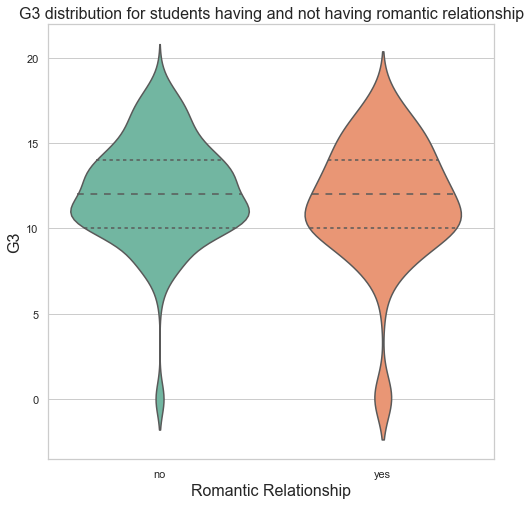

In [15]:
# create violin plots with seaborn
sns.set(style="whitegrid")
fig = plt.figure(figsize=(8, 8))
ax = sns.violinplot(x = df.romantic, y = df.G3, palette="Set2", inner="quartile")
plt.title('G3 distribution for students having and not having romantic relationship',fontsize=16)
plt.xlabel('Romantic Relationship', fontsize=16)
plt.ylabel('G3', fontsize=16)


**Boxplot**

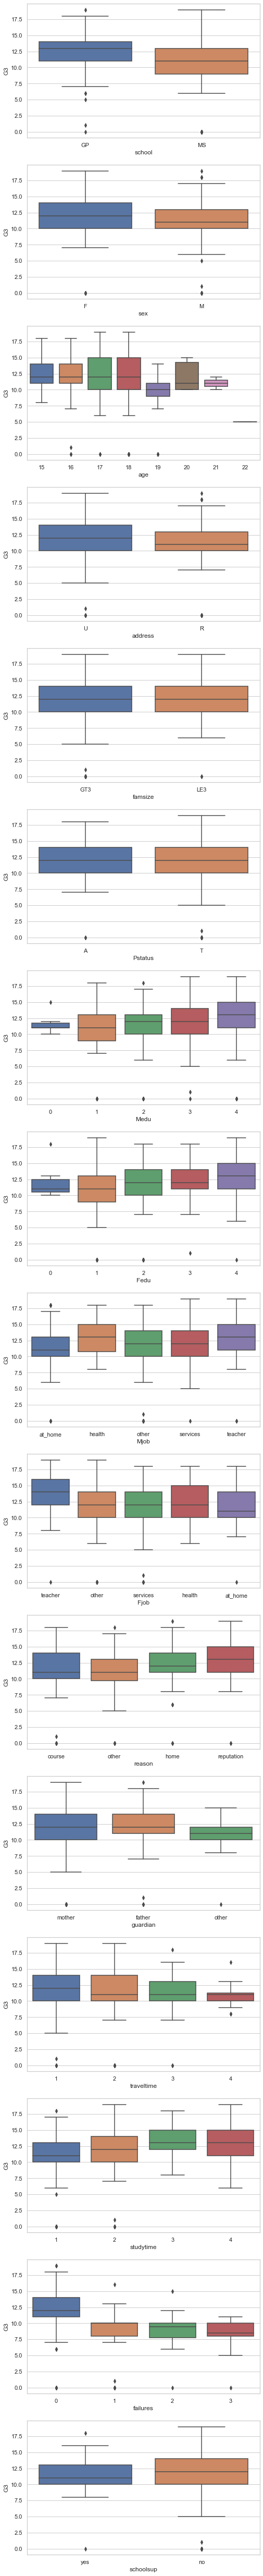

In [16]:
fig, axs = plt.subplots(16, figsize = (8,90))
for i, ax in enumerate(axs.flatten()):
    sns.boxplot(df[df.columns[i]], df['G3'], ax=ax)

Variables for which G3 grades vary:
    
- Type of School : students from MS school tend to have lower G3 grades
- Males tend to have lower G3 grades on average 
- Younger students tend to have better grades
- Mother's education and father's education seem to have an impact on grades
- Mother's job and father's job as well

**Nested Pie chart**

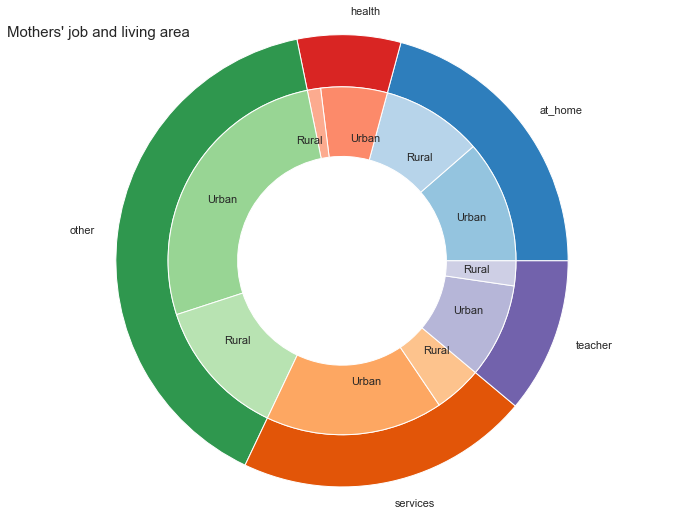

In [30]:
#data for the pie charts
group_names = list(Counter(df.Mjob).keys())
sizes = list(Counter(df.Mjob).values())

labels_address = ['Urban','Rural'] * 5


grouped = df.groupby(["Mjob"]).agg({"address": Counter})
sizes_address = []
for i in range(len(Counter(df.Mjob).keys())):
    sizes_address.append(list(grouped.address[i].values())[0])
    sizes_address.append(list(grouped.address[i].values())[1])

# Create colors
a, b, c, d, e=[plt.cm.Blues, plt.cm.Reds, plt.cm.Greens, plt.cm.Oranges, plt.cm.Purples]

fig, ax = plt.subplots()
fig.set_size_inches(12,8)
ax.axis('equal')
mypie, _ = ax.pie(sizes, radius=1.3, labels=group_names,colors= 
[a(0.7), b(0.7), c(0.7), d(0.7), e(0.7)])
plt.setp( mypie, width=0.3, edgecolor='white')

# Second Ring (Inside)
mypie2, _ = ax.pie(sizes_address, radius=1.3-0.3, 
labels= labels_address, labeldistance=0.7, colors=[a(0.4), a(0.3), 
b(0.4), b(0.3), c(0.4), c(0.3), d(0.4), d(0.3), e(0.4), e(0.3)])
plt.setp( mypie2, width=0.4, edgecolor='white')
plt.margins(0,0)

ax.set_title(label="Mothers' job and living area",loc='left',fontsize=15)
plt.show()

This graph enables to see the difference of repartition Urban/rural according to the mother job : it enables us to see for example that if usually there are more people urban than rural, for students whose mother is at home, the proportion is mch more balanced, with almost the same number of students in urban than in rural area.

**Radar Chart**

In [43]:
## getting 1st and second quantile of G3 grades 
df['G3'].describe()

Out[92]: count 649.000000
mean 11.906009
std 3.230656
min 0.000000
25% 10.000000
50% 12.000000
75% 14.000000
max 19.000000
Name: G3, dtype: float64

In [32]:
## Creating data for the radar chart
Q1 = df[df['G3'] <= 10]
Q3 = df[df['G3'] >= 14]

Q1_spider = Q1[['studytime', 'absences','failures','health', 'goout','traveltime', 'freetime', 'famrel','Dalc','Walc']]
Q3_spider = Q3[['studytime', 'absences','failures','health', 'goout','traveltime', 'freetime', 'famrel','Dalc','Walc']]

In [45]:
import plotly.graph_objects as go

# Define categories
categories = ['Studytime', 'Absences', 'Failures','Health Status', 
              'Going out', 'Traveltime','Freetime', 
              'Quality of Family relationships',
              'Workday Alcohol Consumption','Weekend Alcohol Consumption']


fig = go.Figure()

# First radar chart
fig.add_trace(go.Scatterpolar(
      r=[np.mean(Q1_spider['studytime']), np.mean(Q1_spider['absences']),
         np.mean(Q1_spider['failures']), np.mean(Q1_spider['health']), 
         np.mean(Q1_spider['goout']), np.mean(Q1_spider['traveltime']),
         np.mean(Q1_spider['freetime']), np.mean(Q1_spider['famrel']),
         np.mean(Q1_spider['Dalc']),np.mean(Q1_spider['Walc'])],
        theta=categories,
        fill='toself',
        name='G3 below 1st quartile'
))

#Second radar chart
fig.add_trace(go.Scatterpolar(
      r=[np.mean(Q3_spider['studytime']), np.mean(Q3_spider['absences']),
         np.mean(Q3_spider['failures']), np.mean(Q3_spider['health']), 
         np.mean(Q3_spider['goout']), np.mean(Q3_spider['traveltime']),
         np.mean(Q3_spider['freetime']), np.mean(Q3_spider['famrel']),
         np.mean(Q3_spider['Dalc']),np.mean(Q3_spider['Walc'])],
        theta=categories,
        fill='toself',
        name='G3 above 3rd quartile'
))


fig.update_layout(title='Students Profile by Grades Group',
  polar=dict(
    radialaxis=dict(
      visible=True,
      range=[0, 5]
    )),
  showlegend=True
)



fig.show()

This radar chart is very useful as it enables to see very quickly important features correlated to low or high grades : for example, high grades correspond to a lower level of absence, to a lower level of alcohol consumption, and a lower travaltime and level of going out than low grades.

### Discretization - Target variable G3

We use a five level discretization as suggested in the paper by P. Cortez and A. Silva. Using Data Mining to Predict Secondary School Student Performance

In [54]:
df['G3_discret'] = np.where(df['G3']<=9 , "fail",
                            np.where((9 < df['G3']) & (df['G3'] <=11), "Sufficient",
                                np.where((11 < df['G3']) & (df['G3'] <=13), "Satisfactory", 
                                    np.where((13 < df['G3']) & (df['G3'] <=15), "Good",
                                                "Excellent"))))

df['G2_discret'] = np.where(df['G2']<=9 , "fail",
                            np.where((9 < df['G2']) & (df['G2'] <=11), "Sufficient",
                                np.where((11 < df['G2']) & (df['G2'] <=13), "Satisfactory", 
                                    np.where((13 < df['G2']) & (df['G2'] <=15), "Good",
                                                "Excellent"))))
df['G1_discret'] = np.where(df['G1']<=9 , "fail",
                            np.where((9 < df['G1']) & (df['G1'] <=11), "Sufficient",
                                np.where((11 < df['G1']) & (df['G1'] <=13), "Satisfactory", 
                                    np.where((13 < df['G1']) & (df['G1'] <=15), "Good",
                                                "Excellent"))))

**Parallel plot**

In [48]:
fig = px.parallel_coordinates(df[['G1', 'G2','G3']],
                                labels= {"G1": "G1", "G2": "G2","G3": "G3"}, color="G3",
                                color_continuous_scale=px.colors.diverging.Tealrose,
                                color_continuous_midpoint=10,
                                title ='Evolution of grades')
fig.show()

This graph is useful to see the correlations between G1, G2 and G3 : it exhibits clearly the strong relation between these variables, since there seems to be almost no lines going from bottom to top, which shows that grades remain constant between G1, G2 and G3.

**Bubble chart**

3 dimensions: 
- Average G3 grades
- Average number of absences
- Father's job

In [52]:
# Create data for the bubble chart
df = df.rename(columns={"Fjob": "Father's job"})
group2 = df.groupby(["Father's job"]).agg({"G1": np.mean,
                                   "G2": np.mean,
                                   "G3": np.mean, 
                                   "absences": np.mean})
## Create the size of the bubbles
group2['count'] = df["Father's job"].value_counts()

colorsIdx = {'At_home': 'blue', 'Health': 'green', 'other': 'orange',
              'services': 'pink', 'teacher': 'purple'}

fig = px.scatter(group2.reset_index(), x="absences", y="G3",
                  size = "count", color="Father's job", color_discrete_map=colorsIdx,
                  hover_name="Father's job", log_x=True, size_max=60)


fig.update_layout(title_text="Average Grade with respect to Fathers' Job and Absences", 
                  xaxis_title="Average number of absences",
                  yaxis_title="Average grade")

fig.update_layout(
    legend=dict(
        x=1,
        y=1,
        traceorder="normal",
        font=dict(
            family="sans-serif",
            size=12,
            color="black"
        ),
        bgcolor="LightSteelBlue",
        bordercolor="Black",
        borderwidth=2
    )
)



fig.show()

This graph enables to see clearly the importance of father's job, especially if he is a teacher (low number of absence and higher grades), or oppositely to have him at home (very high number of absence).

**Animated barchart**

Showing the evolution of grades from G1 to G3

In [55]:
## Creating data for the animated barchart
my_list = ['fail', 'Sufficient', 'Satisfactory', 'Good', 'Excellent']

G1_dict = dict(df['G1_discret'].value_counts())
G1_dict = sorted(G1_dict.items(), key=lambda pair: my_list.index(pair[0]))

G2_dict = dict(df['G2_discret'].value_counts())
G2_dict = sorted(G2_dict.items(), key=lambda pair: my_list.index(pair[0]))

G3_dict = dict(df['G3_discret'].value_counts())
G3_dict = sorted(G3_dict.items(), key=lambda pair: my_list.index(pair[0]))

In [56]:
G1 = pd.DataFrame(G1_dict, columns =['Name', 'Count'])
G2 = pd.DataFrame(G2_dict, columns =['Name', 'Count'])
G3 = pd.DataFrame(G3_dict, columns =['Name', 'Count'])
barchart = pd.concat([G1, G2, G3], ignore_index=True)
barchart['Period'] = ['G1'] * 5 + ['G2'] * 5 + ['G3'] * 5
barchart

,Name,Count,Period
0,fail,157,G1
1,Sufficient,186,G1
2,Satisfactory,154,G1
3,Good,106,G1
4,Excellent,46,G1
5,fail,145,G2
6,Sufficient,186,G2
7,Satisfactory,166,G2
8,Good,92,G2
9,Excellent,60,G2


In [57]:
fig = px.bar(barchart, x="Name", y="Count",
            animation_frame='Period', height=600)

fig.update_layout(title_text='Evolution of grades', 
                  xaxis_title="Levels",
                  yaxis_title="Count")
fig.show()

Thanks to this graph, we can see that the distribution of grades goes progressively from left to right, with a global center of distribution going to the right.

In [60]:
# Re-renaming variables
df = df.rename(columns={"Father's job": "Fjob"})

# Create dummies for categorical variables
dummies = pd.get_dummies(df[catVar])

In [61]:
dfModel = df[numVar].join(dummies, lsuffix='_caller', rsuffix='_other')
dfModel = dfModel.join(df['G1_discret'], lsuffix='_caller', rsuffix='_other')
dfModel = dfModel.join(df['G2_discret'], lsuffix='_caller', rsuffix='_other')
dfModel = dfModel.join(df['G3_discret'], lsuffix='_caller', rsuffix='_other')
dfModel.dtypes

Out[31]: age int32
Medu int32
Fedu int32
traveltime int32
studytime int32
failures int32
famrel int32
freetime int32
goout int32
Dalc int32
Walc int32
health int32
absences int32
G1 int32
G2 int32
G3 int32
schoolsup int64
famsup int64
paid int64
activities int64
nursery int64
higher int64
internet int64
romantic int64
school_GP uint8
school_MS uint8
sex_F uint8
sex_M uint8
address_R uint8
address_U uint8
famsize_GT3 uint8
famsize_LE3 uint8
Pstatus_A uint8
Pstatus_T uint8
Mjob_at_home uint8
Mjob_health uint8
Mjob_other uint8
Mjob_services uint8
Mjob_teacher uint8
Fjob_at_home uint8
Fjob_health uint8
Fjob_other uint8
Fjob_services uint8
Fjob_teacher uint8
reason_course uint8
reason_home uint8
reason_other uint8
reason_reputation uint8
guardian_father uint8
guardian_mother uint8
guardian_other uint8
G1_discret object
G2_discret object
G3_discret object
dtype: object

# Exploratory Analysis on Spark

Here we will continue to explore our data, using aggregation functions to get some numbers that will enable to understand lower and higher grades.

In [63]:
df = spark.read\
.format("csv")\
.option("header", "true")\
.option("sep", ";")\
.option("inferSchema", "true")\
.load("/FileStore/tables/student_por-3edc6.csv")

In [64]:
# We just add an index starting at 0
df = df.withColumn("id", 
                   row_number().over(Window.orderBy(monotonically_increasing_id())) - 1
)

# We move it to first position
df = df.select([df.columns[-1]] + df.columns[:-1])

In [65]:
# Basic information
l = [f.dataType for f in df.schema.fields]
print('dataframe col types: ', [[x, l.count(x)] for x in set(l)])

dataframe col types: [[StringType, 17], [IntegerType, 17]]

#### Let's start with simple countings for some qualitative variables

In [67]:
# School
print("More students go to Gabriel Pereira school")
df.groupBy('school').count().show()

# Sex
print("There are more girls than boys in both schools")
df.groupBy('school', 'sex').count().orderBy('school').show()

# Age
print("Very few students are over 18")
df.groupBy('age').count().orderBy('age').show()

# Adress
print("Most of the students live in an urban (rather than rural) area")
df.groupBy('address').count().show()

# Family size
print("The majority of students come from a numerous family (greater than 3 members)")
df.groupBy('famsize').count().show()

More students go to Gabriel Pereira school
+------+-----+
school|count|
+------+-----+
 MS| 226|
 GP| 423|
+------+-----+

There are more girls than boys in both schools
+------+---+-----+
school|sex|count|
+------+---+-----+
 GP| M| 186|
 GP| F| 237|
 MS| M| 80|
 MS| F| 146|
+------+---+-----+

Very few students are over 18
+---+-----+
age|count|
+---+-----+
 15| 112|
 16| 177|
 17| 179|
 18| 140|
 19| 32|
 20| 6|
 21| 2|
 22| 1|
+---+-----+

Most of the students live in an urban (rather than rural) area
+-------+-----+
address|count|
+-------+-----+
 U| 452|
 R| 197|
+-------+-----+

The majority of students come from a numerous family (greater than 3 members)
+-------+-----+
famsize|count|
+-------+-----+
 LE3| 192|
 GT3| 457|
+-------+-----+

In [68]:
# Romantic
print("Among younger students, fewer of them are in a relationship")
query_string = "WITH t1 AS \
(SELECT age, romantic, COUNT(romantic) AS nb_romantic \
FROM new_view \
GROUP BY age, romantic) \
SELECT age, romantic, nb_romantic, \
ROUND((0.0 + nb_romantic)/(SUM(nb_romantic) OVER (PARTITION BY age)) * 100, 2) as prop_by_age \
FROM t1 \
ORDER BY age, romantic"

df.createOrReplaceTempView("new_view") # creates a local temporary table accessible by a SQL query
spark.sql(query_string).show()

Among younger students, fewer of them are in a relationship
+---+--------+-----------+-----------+
age|romantic|nb_romantic|prop_by_age|
+---+--------+-----------+-----------+
 15| no| 84| 75.00|
 15| yes| 28| 25.00|
 16| no| 122| 68.93|
 16| yes| 55| 31.07|
 17| no| 109| 60.89|
 17| yes| 70| 39.11|
 18| no| 76| 54.29|
 18| yes| 64| 45.71|
 19| no| 17| 53.13|
 19| yes| 15| 46.88|
 20| no| 1| 16.67|
 20| yes| 5| 83.33|
 21| no| 1| 50.00|
 21| yes| 1| 50.00|
 22| yes| 1| 100.00|
+---+--------+-----------+-----------+

### Some results about the target variable G3 and how other variables relate to it

G3: final grade (numeric: from 0 to 20, output target)

In [70]:
# General
df.agg(
  fn.min('G3').alias('min_final_grade'),
  fn.max('G3').alias('max_final_grade'),
  fn.round(fn.avg('G3'), 2).alias('avg_final_grade')).show()

# Sex
result_1b = df.groupBy('sex').agg(
  fn.min('G3').alias('min_final_grade'),
  fn.max('G3').alias('max_final_grade'),
  fn.round(fn.avg('G3'), 2).alias('avg_final_grade'))
result_1b.show()

+---------------+---------------+---------------+
min_final_grade|max_final_grade|avg_final_grade|
+---------------+---------------+---------------+
 0| 19| 11.91|
+---------------+---------------+---------------+

+---+---------------+---------------+---------------+
sex|min_final_grade|max_final_grade|avg_final_grade|
+---+---------------+---------------+---------------+
 F| 0| 19| 12.25|
 M| 0| 19| 11.41|
+---+---------------+---------------+---------------+

In [71]:
# We can add a final grade range column so that it is easier to see things
# Notation goes from 0 to 20 so partition is based on the French system
grade_range = fn.when(df.G3 <= 9, "[0, 9]")\
  .when(df.G3 <= 13, "[10, 13]")\
  .when(df.G3 <= 15, "[14, 15]")\
  .otherwise('[16, 20]')

df = df.withColumn("grade_range", grade_range)

In [72]:
# Simple count grade ranges
print("Most of the student's final grades are between 10 and 13")
df.groupBy('grade_range').count().orderBy("grade_range").show()

Most of the student's final grades are between 10 and 13
+-----------+-----+
grade_range|count|
+-----------+-----+
 [0, 9]| 100|
 [10, 13]| 355|
 [14, 15]| 112|
 [16, 20]| 82|
+-----------+-----+

In [73]:
# Grade range by sex
print("The conditional distribution of grades for the sub population of girls is shifted to the right compared to the one for boys")
print("In other words, there are proportionally more girls than boys in higher grade ranges")

query_string = "WITH t1 AS \
(SELECT sex, grade_range, COUNT(grade_range) AS nb_grade_range \
FROM new_view \
GROUP BY sex, grade_range) \
SELECT sex, grade_range, nb_grade_range, \
ROUND((0.0 + nb_grade_range)/(SUM(nb_grade_range) OVER (PARTITION BY sex)) * 100, 2) as prop_by_sex \
FROM t1 \
ORDER BY sex, grade_range"

df.createOrReplaceTempView("new_view") # creates a local temporary table accessible by a SQL query
spark.sql(query_string).show()

The conditional distribution of grades for the sub population of girls is shifted to the right compared to the one for boys
In other words, there are proportionally more girls than boys in higher grade ranges
+---+-----------+--------------+-----------+
sex|grade_range|nb_grade_range|prop_by_sex|
+---+-----------+--------------+-----------+
 F| [0, 9]| 50| 13.05|
 F| [10, 13]| 204| 53.26|
 F| [14, 15]| 73| 19.06|
 F| [16, 20]| 56| 14.62|
 M| [0, 9]| 50| 18.80|
 M| [10, 13]| 151| 56.77|
 M| [14, 15]| 39| 14.66|
 M| [16, 20]| 26| 9.77|
+---+-----------+--------------+-----------+

In [74]:
# Grade range by age
print("Average grade almost doesn't vary among under-18s")
result_3 = df.groupBy('age').agg(
  fn.count('G3').alias('nb_final_grades'),
  fn.round(fn.avg('G3'), 2).alias('avg_final_grade'),
  fn.min('G3').alias('min_final_grade'),
  fn.max('G3').alias('max_final_grade')).orderBy('age')

result_3.show()

Average grade almost doesn't vary among under-18s
+---+---------------+---------------+---------------+---------------+
age|nb_final_grades|avg_final_grade|min_final_grade|max_final_grade|
+---+---------------+---------------+---------------+---------------+
 15| 112| 12.11| 8| 18|
 16| 177| 11.99| 0| 18|
 17| 179| 12.27| 0| 19|
 18| 140| 11.77| 0| 19|
 19| 32| 9.53| 0| 14|
 20| 6| 12.0| 10| 15|
 21| 2| 11.0| 10| 12|
 22| 1| 5.0| 5| 5|
+---+---------------+---------------+---------------+---------------+

In [75]:
# Grade range by freetime (free time after school (numeric: from 1 - very low to 5 - very high))
print("In general, the average final grade is not very dependent of the amount of free time after school")
result_4 = df.groupBy('freetime').agg(
  fn.count('G3').alias('nb_final_grades'),
  fn.round(fn.avg('G3'), 2).alias('avg_final_grade'),
  fn.min('G3').alias('min_final_grade'),
  fn.max('G3').alias('max_final_grade')).orderBy('freetime')

result_4.show()

In general, the average final grade is not very dependent of the amount of free time after school
+--------+---------------+---------------+---------------+---------------+
freetime|nb_final_grades|avg_final_grade|min_final_grade|max_final_grade|
+--------+---------------+---------------+---------------+---------------+
 1| 45| 11.73| 7| 19|
 2| 107| 12.71| 0| 19|
 3| 251| 12.06| 0| 18|
 4| 178| 11.71| 0| 18|
 5| 68| 10.69| 0| 18|
+--------+---------------+---------------+---------------+---------------+

In [76]:
# Grade range by Dalc + Walk
# workday + weekend alcohol consumption (numeric: from 1 - very low to 5 - very high)
print("Workday and weekend alcohol consumption decrease the average final grade but very slightly")
df.groupBy('Dalc').agg(
  fn.count('G3').alias('nb_final_grades'),
  fn.round(fn.avg('G3'), 2).alias('avg_final_grade'),
  fn.min('G3').alias('min_final_grade'),
  fn.max('G3').alias('max_final_grade')).orderBy('Dalc').show()

df.groupBy('Walc').agg(
  fn.count('G3').alias('nb_final_grades'),
  fn.round(fn.avg('G3'), 2).alias('avg_final_grade'),
  fn.min('G3').alias('min_final_grade'),
  fn.max('G3').alias('max_final_grade')).orderBy('Walc').show()

Workday and weekend alcohol consumption decrease the average final grade but very slightly
+----+---------------+---------------+---------------+---------------+
Dalc|nb_final_grades|avg_final_grade|min_final_grade|max_final_grade|
+----+---------------+---------------+---------------+---------------+
 1| 451| 12.3| 0| 19|
 2| 121| 11.36| 0| 18|
 3| 43| 11.14| 8| 18|
 4| 17| 8.94| 0| 14|
 5| 17| 10.24| 5| 16|
+----+---------------+---------------+---------------+---------------+

+----+---------------+---------------+---------------+---------------+
Walc|nb_final_grades|avg_final_grade|min_final_grade|max_final_grade|
+----+---------------+---------------+---------------+---------------+
 1| 247| 12.36| 0| 19|
 2| 150| 12.26| 0| 18|
 3| 120| 11.67| 0| 18|
 4| 87| 11.03| 0| 19|
 5| 45| 10.56| 0| 17|
+----+---------------+---------------+---------------+---------------+

In [77]:
# Grade range by absences range (let's do one more)
# (numeric: from 0 to 93)

# absences partition (it's easier to have an overview if we discretize)
absences_range = fn.when(df.absences == 0, "[0]")\
  .when(df.absences <= 10, "[1, 10]")\
  .when(df.absences <= 20, "[11, 20]")\
  .otherwise('[21-93]')

df = df.withColumn("absences_range", absences_range)

print("The average final grade decreases with the number of abscences")
df.groupBy('absences_range').agg(
  fn.count('G3').alias('nb_final_grades'),
  fn.round(fn.avg('G3'), 2).alias('avg_final_grade'),
  fn.min('G3').alias('min_final_grade'),
  fn.max('G3').alias('max_final_grade')).orderBy('absences_range').show()

The average final grade decreases with the number of abscences
+--------------+---------------+---------------+---------------+---------------+
absences_range|nb_final_grades|avg_final_grade|min_final_grade|max_final_grade|
+--------------+---------------+---------------+---------------+---------------+
 [0]| 244| 12.04| 0| 19|
 [1, 10]| 356| 11.99| 6| 19|
 [11, 20]| 41| 10.63| 5| 17|
 [21-93]| 8| 10.75| 6| 16|
+--------------+---------------+---------------+---------------+---------------+

### Using filters

In [79]:
# We want to detect bad / good students
# Bad students are defined as those for whom grades decreased every semester, excluding those above 16 in their average grade.

progress = fn.when((df.G1 + df.G2 + df.G3) / 3 >= 16, 'good')\
  .when(df.G2 >= df.G1, 'good')\
  .when(df.G3 >= df.G2, 'good')\
  .otherwise('bad')

encouraging_students = df.withColumn('progress', progress).filter(fn.col('progress') == 'bad')

print('In total, there are only', encouraging_students.count(), 'bad students among the two schools. Here is their progression:')
encouraging_students.select("G1", "G2", "G3", 'progress').show()

In total, there are only 8 bad students among the two schools. Here is their progression:
+---+---+---+--------+
 G1| G2| G3|progress|
+---+---+---+--------+
 14| 13| 12| bad|
 10| 9| 8| bad|
 9| 7| 6| bad|
 11| 9| 0| bad|
 14| 13| 12| bad|
 8| 7| 0| bad|
 8| 6| 0| bad|
 7| 5| 0| bad|
+---+---+---+--------+

### We can also do aggregations using window functions

In [81]:
# Comparing final grades by health status
# (numeric: from 1 - very bad to 5 - very good) 

window_spec = Window.partitionBy('health')

new_column = fn.avg('G3').over(window_spec)
df.withColumn('avg_final_grade_by_health', new_column)\
  .groupBy('health')\
  .agg(fn.max('avg_final_grade_by_health').alias('avg_final_grade_by_health'))\
  .orderBy('health').show()
print("Final grade tends to slightly increase as the health status gets worse(!!)")

+------+-------------------------+
health|avg_final_grade_by_health|
+------+-------------------------+
 1| 12.477777777777778|
 2| 12.192307692307692|
 3| 11.838709677419354|
 4| 12.305555555555555|
 5| 11.46987951807229|
+------+-------------------------+

Final grade tends to slightly increase as the health status gets worse(!!)

### Clustering

Our next goal is to apply some clustering to see if we can find meaningful groups of students.

For this we will use the kMeans algorithm. Two remarks before starting: first, it makes no sense to use kMeans on qualitative variables, because it uses euclidian distances, which has poor meaning even if we one-hot-encode them. Hence, we will restrict ourselves to quantiative data. Second, we thought it would be nicer to have some graphical representation (at the end of the day, let's not forget that this is just an exploratory analysis), so we will work on a 3D space.

In [84]:
sub_df = df.select('id', 'age', 'absences', 'G3')
kMeans_features = ['age', 'absences', 'G3']

# Casting everything to float type, except 'id'
for col in sub_df.columns:
  if col in kMeans_features:
    sub_df = sub_df.withColumn(col, sub_df[col].cast('float'))


# We vectorize the three numerical columns, and we assemble everything in a single column 'features_before_scaling' 
vecAssembler = VectorAssembler(inputCols = kMeans_features, outputCol = "features_before_scaling")
df_kmeans = vecAssembler.transform(sub_df)


# We need to standardize the variables because their scales are quite heterogeneous
scaler = StandardScaler(inputCol="features_before_scaling", outputCol="features",
                        withStd=True, # they will have unit variance
                        withMean=True) # they will have zero mean
scalerModel = scaler.fit(df_kmeans) # we fit the StandrdScaler on our data
scaledData = scalerModel.transform(df_kmeans)

In [85]:
# kMeans requires to know the number of clusters k it should try to find in advance
# To choose a good k, we cluster a randomly sampled fraction of the data (20%), without replacement, for different choices of k (from 2 to 25) and look for an "elbow" in the cost function
cost = []
for k in range(2,25):
  kmeans = KMeans().setK(k).setSeed(19).setFeaturesCol("features")
  model = kmeans.fit(scaledData.sample(False, 0.10, seed=1234)) # seed is important for reproducible results
  cost.append(model.computeCost(scaledData))

# Plot
fig, ax = plt.subplots(1, 1, figsize =(8,6))
ax.plot(range(2,25), cost)
ax.set_xlabel('k')
ax.set_ylabel('cost')

Looks like the elbow is around k=7, so this will be our optimal k.

In [87]:
# We are now ready to train the model on the full dataset
k = 7
kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
model = kmeans.fit(scaledData)
centers = model.clusterCenters()

# Once the training has converged we can print out the centroids of the XXXX clusters
print("Cluster Centers: ")
for center in centers:
  print(center)

Cluster Centers: 
[-0.01189697 -0.33235061 -0.67084528]
[-1.0501456 -0.2994071 0.09719101]
[ 0.50849302 4.14794554 -0.22416222]
[ 0.50030197 1.58700644 -0.42765893]
[ 1.13945213 -0.27566846 0.07258173]
[ 0.77436087 -0.78855124 -3.66597631]
[ 0.13396313 -0.30571194 1.31882104]

In [88]:
# We add the prediction column to the dataframe, which tells us the group into which the algorithm has assigned each student.
transformed = model.transform(scaledData).select('id', 'age', 'absences', 'G3', 'prediction')
transformed.show(n=10)

+---+----+--------+----+----------+
 id| age|absences| G3|prediction|
+---+----+--------+----+----------+
 0|18.0| 4.0|11.0| 4|
 1|17.0| 2.0|11.0| 0|
 2|15.0| 6.0|12.0| 1|
 3|15.0| 0.0|14.0| 1|
 4|16.0| 0.0|13.0| 1|
 5|16.0| 6.0|13.0| 1|
 6|16.0| 0.0|13.0| 1|
 7|17.0| 2.0|13.0| 4|
 8|15.0| 0.0|17.0| 1|
 9|15.0| 0.0|13.0| 1|
+---+----+--------+----+----------+
only showing top 10 rows

In [89]:
# Results visualization
pddf_pred = transformed.toPandas().set_index('id') # we need to reconvert everything to a pandas dataframe

threedee = plt.figure(figsize=(12,10)).gca(projection='3d')
threedee.scatter(pddf_pred.age, pddf_pred.absences, pddf_pred.G3, c=pddf_pred.prediction)
threedee.set_xlabel('age')
threedee.set_ylabel('absences')
threedee.set_zlabel('G3')
plt.show()

On this graph, we can see the different clusters, for example in black the cluster of young people with low number of absence and high grades, compared to other clusters, for example in purple with a lot of absences and older students.

#Predicting the grades

## With a regression tree using sklearn regressor

In [93]:
X= dfModel.drop(['G1_discret', 'G2_discret', 'G3', 'G3_discret', 'G1', 'G2'], axis=1)
Y = dfModel['G3']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

In [94]:
params = {'max_depth': [2,3,4,5,6,7,8]}
grid_search_cv = GridSearchCV(DecisionTreeRegressor(random_state=42), params, verbose=1, cv=3)
grid_search_cv.fit(X_train, y_train)

Fitting 3 folds for each of 7 candidates, totalling 21 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 21 out of 21 | elapsed: 0.4s finished
Out[53]: GridSearchCV(cv=3, error_score='raise-deprecating',
 estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
 max_leaf_nodes=None, min_impurity_decrease=0.0,
 min_impurity_split=None, min_samples_leaf=1,
 min_samples_split=2, min_weight_fraction_leaf=0.0,
 presort=False, random_state=42, splitter='best'),
 fit_params=None, iid='warn', n_jobs=None,
 param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8]},
 pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
 scoring=None, verbose=1)

In [95]:
grid_search_cv.best_estimator_

Out[54]: DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
 max_leaf_nodes=None, min_impurity_decrease=0.0,
 min_impurity_split=None, min_samples_leaf=1,
 min_samples_split=2, min_weight_fraction_leaf=0.0,
 presort=False, random_state=42, splitter='best')

In [96]:
clf = grid_search_cv.best_estimator_
clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("MSE:",metrics.mean_squared_error(y_test, y_pred))
print("MAE:",metrics.mean_absolute_error(y_test, y_pred))

MSE: 11.145654964748825
MAE: 2.50992680826636

In [97]:
# On mac, please execute the following command on terminal to get the tree: brew install graphviz 

dot_data = tree.export_graphviz(clf, 
                                out_file = None,
                                feature_names = X.columns,
                                class_names = Y,
                                filled = True,
                                rounded = True,  
                                special_characters = True)  
graph = graphviz.Source(dot_data)  
graph 

Out[56]: <graphviz.files.Source at 0x7f6be2d9f668>

## With random forest and gradient boosting algorithms

Separate into a training and a testing set

In [100]:
train, test = df.randomSplit([0.8, 0.2])

We create the indexers

In [102]:
# ONE-HOT-ENCODING CATEGORICAL DATA
categorical_columns = df.columns
categorical_columns.remove('age')
categorical_columns.remove('absences')
categorical_columns.remove('G1')
categorical_columns.remove('G2')
categorical_columns.remove('G3')

# We start by indexing categorical columns (of type string)
indexers = [
  StringIndexer(inputCol=c, outputCol="{0}_indexed".format(c)) for c in categorical_columns
]

# We encode of the indexed columns
encoders = [
  OneHotEncoder(dropLast=False, inputCol=indexer.getOutputCol(), outputCol="{0}_encoded".format(indexer.getOutputCol())) for indexer in indexers
]

# We vectorize encoded columns
assembler = VectorAssembler(inputCols=['G1','G2','age','absences']+[encoder.getOutputCol() for encoder in encoders], outputCol="features")


--------------------------------------------------------------------------- 
 TypeError Traceback (most recent call last)
 <command-4033390105889527> in <module> 
 14 # We encode of the indexed columns 
 15 encoders = [
 ---> 16 OneHotEncoder ( dropLast = False , inputCol = indexer . getOutputCol ( ) , outputCol = "{0}_encoded" . format ( indexer . getOutputCol ( ) ) ) for indexer in indexers
 17 ]
 18 

 <command-4033390105889527> in <listcomp> (.0) 
 14 # We encode of the indexed columns 
 15 encoders = [
 ---> 16 OneHotEncoder ( dropLast = False , inputCol = indexer . getOutputCol ( ) , outputCol = "{0}_encoded" . format ( indexer . getOutputCol ( ) ) ) for indexer in indexers
 17 ]
 18 

 TypeError : __init__() got an unexpected keyword argument 'dropLast'

Create the models for the pipeline.

In [104]:
rf_regressor = RandomForestRegressor(labelCol="G3", featuresCol="features", numTrees=30, subsamplingRate=1.0)

gbt_regressor = GBTRegressor(labelCol="G3", featuresCol="features", maxIter=50, maxDepth=4, stepSize=0.01)

Create the evaluators

In [106]:
evaluator_mae = RegressionEvaluator(predictionCol="prediction", labelCol="G3", metricName="mae")
evaluator_rmse = RegressionEvaluator(predictionCol="prediction", labelCol="G3", metricName="rmse")

Run the models and evaluate

In [108]:
pipeline_rf = Pipeline(stages = indexers + encoders + [assembler] + [rf_regressor])
pipeline_gbt = Pipeline(stages = indexers + encoders + [assembler] + [gbt_regressor])

fit_rf = pipeline_rf.fit(train)
predictions_rf = fit_rf.transform(test)

fit_gbt = pipeline_gbt.fit(train)
predictions_gbt = fit_gbt.transform(test)

--------------------------------------------------------------------------- 
 NameError Traceback (most recent call last)
 <command-4033390105889533> in <module> 
 ----> 1 pipeline_rf = Pipeline ( stages = indexers + encoders + [ assembler ] + [ rf_regressor ] ) 
 2 pipeline_gbt = Pipeline ( stages = indexers + encoders + [ assembler ] + [ gbt_regressor ] ) 
 3 
 4 fit_rf = pipeline_rf . fit ( train ) 
 5 predictions_rf = fit_rf . transform ( test ) 

 NameError : name 'encoders' is not defined

In [109]:
print("MAE with random forest = %g" % (evaluator_mae.evaluate(predictions_rf)))
print("RMSE with random forest = %g" % (evaluator_rmse.evaluate(predictions_rf)))

print("MAE with gradient boosting = %g" % (evaluator_mae.evaluate(predictions_gbt)))
print("RMSE with gradient boosting = %g" % (evaluator_rmse.evaluate(predictions_gbt)))

--------------------------------------------------------------------------- 
 NameError Traceback (most recent call last)
 <command-4033390105889534> in <module> 
 ----> 1 print ( "MAE with random forest = %g" % ( evaluator_mae . evaluate ( predictions_rf ) ) ) 
 2 print ( "RMSE with random forest = %g" % ( evaluator_rmse . evaluate ( predictions_rf ) ) ) 
 3 
 4 print ( "MAE with gradient boosting = %g" % ( evaluator_mae . evaluate ( predictions_gbt ) ) ) 
 5 print ( "RMSE with gradient boosting = %g" % ( evaluator_rmse . evaluate ( predictions_gbt ) ) ) 

 NameError : name 'predictions_rf' is not defined

### Another model using another libary : Neural network with keras

First, we create our model.

In [112]:
class our_small_network(keras.Model):
  def __init__(self):
    super(our_small_network, self).__init__()
    self.first = keras.layers.Dense(32,  activation='relu')
    self.dense16 = keras.layers.Dense(16, activation = 'relu')
    self.dense8 = keras.layers.Dense(8, activation = 'relu')
    self.dense1 = keras.layers.Dense(1, activation = 'relu')

  def __call__(self, input_tensor):
    x = self.first(input_tensor)
    x = self.dense16(x)
    x = self.dense8(x)
    x = self.dense1(x)
    return(x)

The second step is to make other functions to be able to customize our model depending on what features we want to use (do we want to use G1 and G2 to predict G3, or only other features)

In [114]:
#function to implement the model depending on our input
def make_our_model(with_G1_G2):
  if with_G1_G2 == False:
    x = keras.Input(shape=(56,))
  if with_G1_G2 == True:
    x = keras.Input(shape=(58,))
  
  y = our_small_network()(x)
  model = keras.Model(inputs = x, outputs = y)
  print(model.summary())

  model.compile(optimizer= 'adam', metrics=['mae'], loss='mae')
  return(model)

#fitting the function with adapted dataset (with dummies and normalized, because NN work better with normalized data)
def fit_our_model(dataset, with_G1_G2):
  grade = dataset.pop('G3')

  if with_G1_G2 == False:
    dataset.drop(['G1','G2'], axis = 1, inplace = True)

  data = pd.get_dummies(dataset)

  scaler = preprocessing.StandardScaler()
  scaled_df = scaler.fit_transform(data)
  scaled_df = pd.DataFrame(scaled_df, columns=data.columns)

  X_train, X_test, y_train, y_test = train_test_split(data, grade, test_size = 0.2)

  m = make_our_model(with_G1_G2)
  m.fit(X_train, y_train, epochs=50, batch_size=20)

  y_test_pred = m.predict(X_test)
  mae = mean_absolute_error(y_test, y_test_pred)

  return("The mean Absolute Error when predicting on test set is ", mae)

The last step is to apply our function to our dataset ; we do it twice, once using G1 and G2, once without them.

In [116]:
dataset = pd.read_csv("/dbfs/FileStore/tables/student_por-3edc6.csv", sep=";", header= 0)
fit_our_model(dataset, True)

Model: "model_4"
_________________________________________________________________
Layer (type) Output Shape Param # 
=================================================================
input_4 (InputLayer) (None, 58) 0 
_________________________________________________________________
dense_13 (Dense) (None, 32) 1888 
_________________________________________________________________
dense_14 (Dense) (None, 16) 528 
_________________________________________________________________
dense_15 (Dense) (None, 8) 136 
_________________________________________________________________
dense_16 (Dense) (None, 1) 9 
=================================================================
Total params: 2,561
Trainable params: 2,561
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
 20/519 [>.............................] - ETA: 3s - loss: 9.6003 - mae: 9.6003519/519 [==============================] - 0s 318us/step - loss: 6.2511 - mae: 6.2511
Epoch 2/50
 20/519 [>.............................] - ETA: 0s - loss: 2.0873 - mae: 2.0873519/519 [==============================] - 0s 62us/step - loss: 1.8554 - mae: 1.8554
Epoch 3/50
 20/519 [>.............................] - ETA: 0s - loss: 1.5973 - mae: 1.5973519/519 [==============================] - 0s 65us/step - loss: 1.3543 - mae: 1.3543
Epoch 4/50
 20/519 [>.............................] - ETA: 0s - loss: 1.1262 - mae: 1.1262519/519 [==============================] - 0s 84us/step - loss: 1.2011 - mae: 1.2011
Epoch 5/50
 20/519 [>.............................] - ETA: 0s - loss: 0.7345 - mae: 0.7345519/519 [==============================] - 0s 70us/step - loss: 1.0332 - mae: 1.0332
Epoch 6/50
 20/519 [>.............................] - ETA: 0s - loss: 0.8819 - mae: 0.8819519/519 [==============================] - 0s 61us/step - loss: 0.9908 - mae: 0.9908
Epoch 7/50
 20/519 [>.............................] - ETA: 0s - loss: 1.4276 - mae: 1.4276519/519 [==============================] - 0s 66us/step - loss: 0.9120 - mae: 0.9120
Epoch 8/50
 20/519 [>.............................] - ETA: 0s - loss: 1.2134 - mae: 1.2134519/519 [==============================] - 0s 61us/step - loss: 0.8704 - mae: 0.8704
Epoch 9/50
 20/519 [>.............................] - ETA: 0s - loss: 1.0382 - mae: 1.0382519/519 [==============================] - 0s 60us/step - loss: 0.8567 - mae: 0.8567
Epoch 10/50
 20/519 [>.............................] - ETA: 0s - loss: 1.0327 - mae: 1.0327519/519 [==============================] - 0s 61us/step - loss: 0.8592 - mae: 0.8592
Epoch 11/50
 20/519 [>.............................] - ETA: 0s - loss: 0.7241 - mae: 0.7241519/519 [==============================] - 0s 61us/step - loss: 0.8386 - mae: 0.8386
Epoch 12/50
 20/519 [>.............................] - ETA: 0s - loss: 0.9313 - mae: 0.9313519/519 [==============================] - 0s 62us/step - loss: 0.8028 - mae: 0.8028
Epoch 13/50
 20/519 [>.............................] - ETA: 0s - loss: 0.6518 - mae: 0.6518

In [117]:
dataset = pd.read_csv("/dbfs/FileStore/tables/student_por-3edc6.csv", sep=";", header= 0)
fit_our_model(dataset, False)

Model: "model_5"
_________________________________________________________________
Layer (type) Output Shape Param # 
=================================================================
input_5 (InputLayer) (None, 56) 0 
_________________________________________________________________
dense_17 (Dense) (None, 32) 1824 
_________________________________________________________________
dense_18 (Dense) (None, 16) 528 
_________________________________________________________________
dense_19 (Dense) (None, 8) 136 
_________________________________________________________________
dense_20 (Dense) (None, 1) 9 
=================================================================
Total params: 2,497
Trainable params: 2,497
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
 20/519 [>.............................] - ETA: 3s - loss: 11.6788 - mae: 11.6788519/519 [==============================] - 0s 316us/step - loss: 10.6683 - mae: 10.6683
Epoch 2/50
 20/519 [>.............................] - ETA: 0s - loss: 8.5829 - mae: 8.5829519/519 [==============================] - 0s 60us/step - loss: 5.5569 - mae: 5.5569
Epoch 3/50
 20/519 [>.............................] - ETA: 0s - loss: 2.7888 - mae: 2.7888519/519 [==============================] - 0s 60us/step - loss: 2.8880 - mae: 2.8880
Epoch 4/50
 20/519 [>.............................] - ETA: 0s - loss: 2.8909 - mae: 2.8909519/519 [==============================] - 0s 65us/step - loss: 2.6099 - mae: 2.6099
Epoch 5/50
 20/519 [>.............................] - ETA: 0s - loss: 2.8479 - mae: 2.8479519/519 [==============================] - 0s 66us/step - loss: 2.3904 - mae: 2.3904
Epoch 6/50
 20/519 [>.............................] - ETA: 0s - loss: 1.4384 - mae: 1.4384519/519 [==============================] - 0s 60us/step - loss: 2.2340 - mae: 2.2340
Epoch 7/50
 20/519 [>.............................] - ETA: 0s - loss: 1.7285 - mae: 1.7285519/519 [==============================] - 0s 61us/step - loss: 2.1470 - mae: 2.1470
Epoch 8/50
 20/519 [>.............................] - ETA: 0s - loss: 1.3617 - mae: 1.3617519/519 [==============================] - 0s 60us/step - loss: 2.1042 - mae: 2.1042
Epoch 9/50
 20/519 [>.............................] - ETA: 0s - loss: 1.3283 - mae: 1.3283519/519 [==============================] - 0s 61us/step - loss: 2.0540 - mae: 2.0540
Epoch 10/50
 20/519 [>.............................] - ETA: 0s - loss: 2.5922 - mae: 2.5922519/519 [==============================] - 0s 62us/step - loss: 2.0241 - mae: 2.0241
Epoch 11/50
 20/519 [>.............................] - ETA: 0s - loss: 2.3707 - mae: 2.3707519/519 [==============================] - 0s 61us/step - loss: 1.9924 - mae: 1.9924
Epoch 12/50
 20/519 [>.............................] - ETA: 0s - loss: 1.3768 - mae: 1.3768519/519 [==============================] - 0s 61us/step - loss: 1.9767 - mae: 1.9767
Epoch 13/50
 20/519 [>.............................] - ETA: 0s - loss: 2.2010 - mae: 2.2010

As expected considering correlations between G1, G2 and G3, the predictions are much better using G1 and G2 than without them (Mean absolute error on test set of 1.88 without them, 0.86 with them).

### Conclusion

To conclude, during this project, we have used various methods (descriptive statistics, graph, aggregation and filter functions, kmeans and predictions with different algorithms) to understand the variables that influence grades and how we can use them to predict the final grade G3.